# Forecast of bike sharing demand

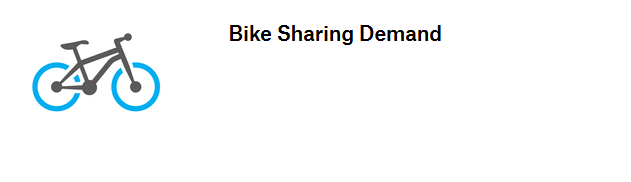


## Input 
Historical usage patterns of bike rental demand combined with weather data.
Provided are hourly rental data spanning two years. The training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month.

## Task
The task is to predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

## Data Fields

**datetime**                   - hourly date + timestamp 

**season**
*  1 = spring, 
*         2 = summer, 
*         3 = fall, 
*         4 = winter 


**holiday**      - whether the day is considered a holiday

**workingday **  - whether the day is neither a weekend nor holiday

**weather** 
* 1    = Clear, Few clouds, Partly cloudy, Partly cloudy
* 2    = Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
* 3    = Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
* 4    = Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 

**temp** - temperature in Celsius

**atemp** - "feels like" temperature in Celsius

**humidity** - relative humidity

**windspeed** - wind speed

**casual** - number of non-registered user rentals initiated (**not available in test set**)

**registered** - number of registered user rentals initiated (**not available in test set**)

**count** - number of total rentals (**not available in test set**)

# Here comes my battle plan

Read in data

Inspect data (Data cleansing necessary?)

Outlier Analysis / Clean & Transform

Feature Engineering

ML approach - short discussion which machine learning approach to use

...

In [ ]:
# global setting to print all the outputs of a code cell (not just the last one)
from IPython.core.interactiveshell import InteractiveShell  
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
#### flag for only executing necessary code (without time-consuming outputs)
speed_up = True

#### flag for output only useful for debugging purposes

debug = True

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings

pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

# exploratory data analysis (EDA) of a Pandas Dataframe
import pandas_profiling

import os
#print(os.listdir("../input"))


# Read data
Read provided train and test set

In [ ]:
# read training and test set 
train = pd.read_csv('../input/bike-sharing-demand/train.csv')
test = pd.read_csv('../input/bike-sharing-demand/test.csv')

# Inspect data

In [ ]:
# create EDA report - takes a moment!
if speed_up != True:
  train.profile_report()

In [ ]:
if speed_up != True:
    type(train)  # display type of train
    train.shape  # display shape of train
    train.dtypes # inspect types of featrues

<div class="alert alert-block alert-warning">  
<b>Important Observations:</b> Thanks to the build-in EDA report of pandas "profile_report" we already can state the following observations about our train dataset:
<p>
<li> 
  10886 observations with 12 features
</li>     
<li> 
  no missing cells / no dublicates
  <br>
  zero values are no issue 
        <div style="text-indent:20px;">- casual "0" means no not-registered person rented a bike on that day</div> 
        <div style="text-indent:20px;">- windspeed "0" means no measurable air movement</div>
  Everything looks reasonable => no data cleansing needed
</li> 
<br>
<li> 
    feature **"registered"** is highly correlated with feature "count" => "registered" and then also "casual" as counterpart can be ignored. Anyhow - **"registered" and "casual"** are not contained in test set and will not be taken in account further, i.e. these features **will be dropped**.
</li> 
<li> 
    feature **"atemp"** (feels like temperature) is highly correlated with feature "temp" (temperature) => "atemp" can be ignored
</li> 
<br>
<li> 
  feature **"datetime"** only contains datetime values, but is categorical => convert type to "datetime"  
</li> 
<li>
    features **"weather", "season", "holiday"** and **"workingday"** are of type numerical => convert to type categorical
</li>
<p>    
The heat diagram also tells us already a few things about correlations. For example, higher temperatures seem to have a positive effect on the number of bicycle rentals, while higher humidity seems to have a rather negative effect on bicycle rentals.

</div>





# Outlier Analysis





In [ ]:
_=sns.boxplot(x = 'count', data = train)
_=plt.title("Boxplot of target variable \"count\"")
plt.show()

The boxplot diagram it tells us more about the target variable 'count':
* the data is right skewed, i.e. median < mean, i.e. not normally distributed
* There are some outliers that exceed the maximum (exceeds the right whisker). 


### Calculate the number of outliers

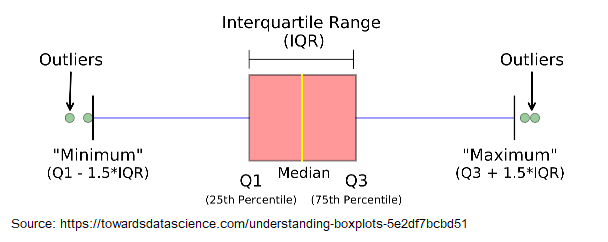


In [ ]:
#### this code section is devoted to calculate the outliers of target variable 'count'
Q1 = train['count'].quantile(0.25)
Q3 = train['count'].quantile(0.75)
IQR = Q3 - Q1
outliers_high = len(train[(train['count'] > (Q3 + 1.5 * IQR))])
outliers_low  = len(train[(train['count'] < (Q1 - 1.5 * IQR)) ])
outliers_all  = outliers_high + outliers_low
print("Outliers exceeding 'maximum' ( > Q3 + 1.5 * IQR): ", outliers_high)
print("Outliers below 'minimum' ( < Q1 - 1.5 * IQR)):    ", outliers_low)
print((outliers_all/len(train))*100)

So we have 300 hours with extraordinary high rental counts in the training set, that are <3% of all training sets.


# To drop or not to drop the outliers?
It is known and obvious that outliers have a bad impact in linear regression models, i.e. if we want to work with linear regression we have to get rid of outliers.

Saying that we should always consider what we lose when we drop data. If we know that a outliers result from a measurement error than it surly would be correct to drop the outliers. In our case it probably is not a measurement error - so we would lose information about the variability in the data.

## First try transformation techniques to tame the outliers

In [ ]:
# use "_" as temporary object to suppress output of function calls
_=sns.distplot(train['count'], bins=25)
_=plt.title("Probability Density of target variable \"count\"")
_=plt.ylabel('Probability Density')
# Limits for the Y axis
_=plt.xlim(0,1100)
plt.show()

The probablility density diagram shows that the data is right-skewed, i.e. not normal distributed

<div class="alert alert-block alert-warning"> 
**Fix for skewness of target variable**
<br>
I will use the Box-Cox method to transform the data in a more normal distributed form.
<br>
This will be done as a last step before I start modelling regressors, i.e.after EDA and normalization of the data is done.
</div>

In [ ]:
# The boxcox() SciPy function implements the Box-Cox method. (Data must be positiv)
# The Box-Cox method is a data transform method that is able to perform a range of power transforms.
# More than that, it can be configured to evaluate a suite of transforms automatically and select a best fit.
# It takes an argument, called lambda, that controls the type of transform to perform.
# Below are some common values for lambda:
# lambda = -1. is a reciprocal transform.
# lambda = -0.5 is a reciprocal square root transform.
# lambda = 0.0 is a log transform.
# lambda = 0.5 is a square root transform.
# lambda = 1.0 is no transform.

# Feature Engineering

**Drop features** (columns) **'atemp'**, **'registered'** and **'casual'** because they correlated strongly with another feature and are therefore redundant.

In [ ]:
# drop reduandant columns 'registered'and 'atemp'
train.drop(['atemp','registered', 'casual'],axis=1,inplace=True)
# same for test ('registered' and 'casual' are not contained in test set anyway)
test.drop(['atemp'],axis=1,inplace=True)

In [ ]:
if speed_up != True:
    train.shape  # display shape of train
    train.dtypes # inspect types of featrues

**Convert** categorical feature **"datetime"** to type **datetime** and extract the following features for the upcoming forcast:
**month**
**hour**

<div class="alert alert-block alert-warning">  
<b>Common sense observation:</b> 
It doesn't matter what day it is in the month, so the "day number of month" information will not be a feature.
<p>
But we want to include the "day_of_week" as a feature. This might give us more insight than just distinguishing between working days and weekends. 
("0" for Monday to "6" for Sunday)
</div>

In [ ]:
#### this code section is devoted to extract features 'year', 'month' and 'hour' information from 'datetime'
#### the no longer needed 'datetime' column will be dropped afterwards

# convert categorical feature 'datetime' to type datetime
train.datetime = pd.to_datetime(train.datetime)

# extract needed features from date information
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month          # january=0 - december=12
train['day_of_week'] = train['datetime'].dt.weekday  # monday=0 - sunday=6
train['hour'] = train['datetime'].dt.hour
#drop column "datetime", which is no longer needed
train.drop(['datetime'],axis=1,inplace=True)

#### same for test data set
test.datetime = pd.to_datetime(test.datetime)
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day_of_week'] = test['datetime'].dt.weekday  # monday=0 - sunday=6
test['hour'] = test['datetime'].dt.hour
test.drop(['datetime'],axis=1,inplace=True)



**Drop** column with column **"datetime"**, which is **no longer needed**.

In [ ]:
if debug != True:
    train.dtypes
    train.head()

**Convert** numeric features  **weather, season, holiday** and **workingday** to categorical features

In [ ]:
if speed_up != True:
    # first make shure that these 'categorical' feaures really only contains
    # the values as defined in the data description
    print("Check for value count for feature 'weather':")
    my_value_counts = train['weather'].value_counts(sort=False)
    my_value_counts.rename_axis('weather categories').reset_index(name='counts')

    print("Check for value count for feature 'season':")
    my_value_counts = train['season'].value_counts(sort=False)
    my_value_counts.rename_axis('season categories').reset_index(name='counts')

    print("Check for value count for feature 'holiday':")
    my_value_counts = train['holiday'].value_counts(sort=False)
    my_value_counts.rename_axis('holiday categories').reset_index(name='counts')

    print("Check for value count for feature 'workingday':")
    my_value_counts = train['workingday'].value_counts(sort=False)
    my_value_counts.rename_axis('workingday categories').reset_index(name='counts')

In [ ]:
# convert features to type categorical
train['weather'] = train['weather'].astype('category')
train['season'] = train['season'].astype('category')
train['holiday'] = train['holiday'].astype('category')
train['workingday'] = train['workingday'].astype('category')

# same for test
test['weather'] = test['weather'].astype('category')
test['season'] = test['season'].astype('category')
test['holiday'] = test['holiday'].astype('category')
test['workingday'] = test['workingday'].astype('category')


In [ ]:
if debug != True:
    train.dtypes
    train.head()

## Repeat EDA-report after all these changes to the dataframe

In [ ]:
if speed_up != True:
    train.profile_report()   # takes a moment to execute

# EDA conclusion:

## Target "count"
The target variable "count" is strongly **right skewed**, i.e. median < mean => apply one of the **common transformations** include **square root**, **cube root**, or **log**
